In [53]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
import scipy
import sys
import time
import control
import random
import os
from torch.optim import Adam
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import matplotlib.pyplot as plt

import numpy as np
from model_archs import LSTM_FF
from model_archs import LSTM_FF_dropout
import scipy.io
np.random.seed(0)

import h5py
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import math
from sklearn.metrics import r2_score

proces_params = {} 

# PARAMETRIZATION
sampl_time = 15/1440 #as in MATLAB files
ts = 15/1440
C = 0
learning_rate = 1e-3
use_prev_prediction = False
batch_size = 1 
test_batch_size = 1
num_epochs = 100
test_size = 0.2
early_stop_thresh = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader_shuffle = False
gradient_clipping = False
sched_sampling = True
prev2 = False 
nodrop = False # dropout in model yes or no
custom_loss = False
pid = {}


print(device)

setpoint_signal = './ETROTLE_Dataset_ETFA24_MAT_files/reference/' 
first_order_processes_mat = './ETROTLE_Dataset_ETFA24_MAT_files/PID_tuning_params_1stO_processes.mat'
pids_mat_dir = './ETROTLE_Dataset_ETFA24_MAT_files/1st_order/' 


cpu


In [54]:
def get_inputs_output (process, process_folder):
    """
    Get training data from the .mat files of a certain tuned PID for a certain process.
    Generate input and output vectors.
    """
    mesura_process = f'mesura_PID_{process}'
    actuacio_process = f'actuacio_PID_{process}'
    
    print(mesura_process)
    
    P1_fold = setpoint_signal 

    print(P1_fold)
    
    So5sim = np.array(scipy.io.loadmat(P1_fold + 'referencia_PID_P1.mat')['referencia_PID_P1']).reshape((-1, 1))
    So5out = np.array(scipy.io.loadmat(process_folder + mesura_process +'.mat')[mesura_process]).reshape((-1, 1))
    kla = np.array(scipy.io.loadmat(process_folder + actuacio_process + '.mat')[actuacio_process]).reshape((-1, 1))
    
    error = So5sim - So5out

    # The previously predicted value as an extra input of the model (NARX models in ANNs)
    kla_delayed = np.vstack([kla[0, :], kla[0:len(kla)-1, :]])

    inputs = np.hstack((So5sim, So5out, error, kla_delayed))
    output = kla.reshape((-1,1))

    if prev2:
        kla_delayed2 = np.vstack([kla[0, :], kla[1,:], kla[0:len(kla)-2, :]])
        inputs = np.hstack((So5sim, So5out, error, kla_delayed, kla_delayed2))        
    
    return inputs, output

def get_datasets_dataloaders (inputs, output, bs=batch_size, testbs=test_batch_size):
    # Split the data into training and testing sets
    #train_inputs, test_inputs, train_output, test_output = train_test_split(inputs, output, test_size=test_size, random_state=42)
    train_inputs, test_inputs, train_output, test_output = train_test_split(inputs, output, test_size=test_size, shuffle=False)

    # Standardize the data separately for training and testing, use scaler for training for scaling test data
    scaler = StandardScaler()
    train_inputs_standardized = scaler.fit_transform(train_inputs)
    test_inputs_standardized = scaler.transform(test_inputs)

    #SCALE OUTPUT DATA

    scaler_out = StandardScaler()
    train_outputs_standardized = scaler_out.fit_transform(train_output)
    test_outputs_standardized = scaler_out.transform(test_output)

    # Convert to PyTorch tensors
    train_inputs_tensor = torch.tensor(train_inputs_standardized, dtype=torch.float32)
    train_output_tensor = torch.tensor(train_outputs_standardized, dtype=torch.float32)

    test_inputs_tensor = torch.tensor(test_inputs_standardized, dtype=torch.float32)
    test_output_tensor = torch.tensor(test_outputs_standardized, dtype=torch.float32)

    # Create PyTorch datasets
    train_dataset = TensorDataset(train_inputs_tensor, train_output_tensor)
    test_dataset = TensorDataset(test_inputs_tensor, test_output_tensor)

    # Create PyTorch DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=train_loader_shuffle)
    test_dataloader = DataLoader(test_dataset, batch_size=testbs, shuffle=False)
    
    print("Scaler data")
    print(scaler.mean_)
    print(scaler.scale_)

    for batch, (inputs, outputs) in enumerate(train_dataloader, 1):
        print(batch, inputs.size(), outputs.size())
        break

    return train_dataset, test_dataset, train_dataloader, test_dataloader, scaler, scaler_out

def plot_and_save_results(tr_losses, te_losses, suffix, experiment_num = 1):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    plt.plot(tr_losses, label='Training Loss', color='blue')
    plt.plot(te_losses, label='Testing Loss', color='red')
    plt.title(f'Training and Testing Loss Over Epochs - Experiment {suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()  
    plt.tight_layout()
    
    # Show the plot
    file_path = f'Results/Plots/Loss_plot_{process}_{suffix}.png'
    # Save the plot
    plt.savefig(file_path)
    
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def mean_absolute_error(output, target):
    return torch.mean(torch.abs(output - target))

def mean_absolute_percentage_error(output, target):
    return torch.mean(torch.abs((target - output) / target)) * 100

def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))
    
def init_weights(m):
    if isinstance(m, torch.nn.LSTM):
        m.reset_parameters()
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()    
        
def inverse_linear_decay(epoch, total_epochs):
    return 0.0 + (epoch / total_epochs)

def inverse_sigmoid_decay(current_epoch, max_epoch=100, k=110):
    #function shape was with 1000 epochs, so we need to map it
    mapped_epoch = current_epoch/max_epoch*1000
    return 1 - (k / (k + np.exp(mapped_epoch / k)))
        
def get_mesura_proces_pidonline(denorm_actuacio, num1, den1, den2, den3, delay, sampling_time = sampl_time, x0 = None):
    """
    Simulate and return process output based on previous state and process dynamics.
    """
    y_out_list = []

    numerator = [num1]
    denominator = [den1, den2, den3]

    # Create the transfer function
    transfer_function = control.TransferFunction(numerator, denominator)

    #PADÉ
    Tau = delay
    N = 10
    [num_pade, den_pade] = control.pade(Tau, N )
    Hpade = control.TransferFunction(num_pade, den_pade)

    # Apply the time delay
    system_with_delay = control.series(transfer_function, Hpade)

    #CONVERT TO STATE SPACE
    ss = control.tf2ss(system_with_delay)

    sample_time = sampling_time
    batch_size = len(denorm_actuacio)

    # Define the time vector
    t = np.linspace(0, (batch_size - 1) * sample_time, batch_size)         
    
    if x0 is None:
        x0 = [0 for i in range(len(ss.A))]
        
    u = denorm_actuacio
    t_out, y_out, x_out = control.forced_response(ss, T=t, U=u, X0=x0, return_x=True)
    #print(u,t_out,y_out)
    #print("X0", x0)
    #print("xout", x_out)
    return y_out.tolist(), t_out, x_out[:,-1] #LIST OF MEASURES OF THE BATCH, LIST OF X0 OF BATCH INSTANCES

        
def IAE_calculator (inputs_iae, model, scaler, scaler_out, pp = "A"):
    """
    One by one simulation pipeline with network recursive predictions over the reference signal,
    365 time, 35041 instances. An instance every 0,010416369 seconds.
    Return control actuations of the model + errors against ground truth.
    """
    actuacions = []
    errors = []

    model.to("cpu")
    model.eval()

    setpoint = inputs_iae[:,0]
    inputs_tensor = torch.empty(inputs_iae[0].shape)
    inputs_tensor = inputs_tensor.unsqueeze(0).unsqueeze(0) #1,1,4 shape
    counter = 1
    X0 = None
    hidden = None

    if prev2:
        prediction = inputs_iae[0,4]
    
    for ref in setpoint: 
        if counter == 1:
            inputs_0_norm = (inputs_iae[0] - scaler.mean_) / scaler.scale_
            inputs_tensor = torch.tensor(inputs_0_norm ,dtype=torch.float32).to("cpu")
            inputs_tensor = inputs_tensor.unsqueeze(0).unsqueeze(0)

            denorm_actuacio_previa = np.array([inputs_iae[0,3]])[0]
            
        else:
            ref_norm = (ref - scaler.mean_[0]) / scaler.scale_[0]
            inputs_tensor[:,:,0] = ref_norm
            inputs_tensor[:,:,3] = prediction
            #NEW
            if prev2:
                inputs_tensor[:,:,4] = prev2_prediction
            denorm_actuacio = scaler_out.scale_ * output_prev_ann + scaler_out.mean_
            actuacions.append(denorm_actuacio)

            denorm_actuacio = [denorm_actuacio_previa, denorm_actuacio[0]]
            mesura_lstm, _ , X0 = get_mesura_proces_pidonline(denorm_actuacio, pp[0], pp[1], pp[2], pp[3], pp[4], x0 = X0)
            denorm_actuacio_previa = denorm_actuacio[-1]
            mesura_lstm = torch.tensor(mesura_lstm[-1]) 

            #Normalize mesura_lstm for putting in inputs
            mesura_lstm_norm = (mesura_lstm - scaler.mean_[1]) / scaler.scale_[1]
            inputs_tensor[:,:,1] = mesura_lstm_norm
            
            #error is denorm ref-mesura and then norm
            error = ref - mesura_lstm
            errors.append(ref - mesura_lstm.item())
            inputs_tensor[:,:,2] = (error - scaler.mean_[2]) / scaler.scale_[2]
            
        with torch.no_grad():
            if prev2:
                prev2_prediction = prediction
            
            prediction = model(inputs_tensor)
            predictions_list = [elem[0] for elem in prediction]

            predictions = torch.tensor(predictions_list)
            output_prev_ann = predictions.numpy().tolist()
        counter +=1
        
        #print(counter, inputs_tensor, prediction)
    return actuacions, errors  
    
class ClassicMSELoss(torch.nn.Module):
    def __init__(self):
        super(ClassicMSELoss, self).__init__()

    def forward(self, predictions, targets, error):
        # Compute the standard MSE loss
        loss = torch.mean((predictions - targets) ** 2)
        return loss


class CustomMSELoss(torch.nn.Module):
    """
    Custom loss class creator. Created for testing purposes, not used in practicality.
    """
    def __init__(self):
        super(CustomMSELoss, self).__init__()
        self.iterations = 0
        self.total_integral_error = 0.0

    def forward(self, predictions, targets, error, batch_size):
        # Compute the standard MSE loss
        mse_loss = torch.mean((predictions - targets) ** 2)
        
        # Compute the integral of the error and accumulate it
        self.total_integral_error += torch.sum(error)
        
        # Update the number of iterations
        self.iterations += batch_size
        
        # Calculate the integral error term
        #integral_error_term = self.total_integral_error / self.iterations
        integral_error_term = error
        #print(self.iterations, self.total_integral_error, integral_error_term)

        # Weight for the integral error term
        weight = 10  # Adjust this parameter as desired
        
        # Add the integral error term to the MSE loss
        loss = mse_loss + weight * integral_error_term
        
        return loss


In [55]:
class PIDController:
    """
    A discretized 2DOF PID controller based on tuning parameters obtained from MATLAB.

    This class implements a PID controller with discretized equations to handle 
    proportional, integral, and derivative actions. The parameters such as Kp, b, 
    Ti, Ts, Td, and c are assumed to be obtained from MATLAB tuning procedures, 
    allowing the controller to be implemented and tested in Python for real-time 
    or simulation purposes.

    Attributes:
    ----------
    Kp : float
        Proportional gain constant.
    b : float
        Setpoint weight for proportional action.
    Ti : float
        Integral time constant.
    Ts : float
        Sampling time interval (discrete time step).
    Td : float
        Derivative time constant.
    c : float
        Setpoint weight for derivative action.
        
    prev_r : float
        Previous setpoint (reference) value.
    prev_y : float
        Previous output (process variable) value.
    prev_integrator : float
        Previous integrator value for the integral action.
    A : float
        Pre-computed coefficient for the integral term.
    B : float
        Pre-computed coefficient for the derivative term.

    Methods:
    -------
    update(r_k, y_k):
        Updates the PID control output based on the current reference (r_k) 
        and output (y_k) using the discretized PID equations.
    """
    def __init__(self, Kp, b, Ti, Ts, Td, c):
        self.Kp = Kp
        self.b = b
        self.Ti = Ti
        self.Ts = Ts
        self.Td = Td
        self.c = c
        
        self.prev_r = 0
        self.prev_y = 0
        self.prev_integrator = 0
        self.A = (self.Kp*self.Ts)/(2*self.Ti)
        self.B = (self.Kp*self.Td)/self.Ts

    def update(self, r_k, y_k):
        # Calculate terms
        prop = self.Kp * (self.b*r_k - y_k)
        inte = self.A * (r_k + self.prev_r - y_k - self.prev_y) + self.prev_integrator
        der = self.B * (self.c*r_k - self.c*self.prev_r - y_k + self.prev_y)

        # Calculate control output
        u_k = prop + inte + der

        # Update previous values for next iteration
        self.prev_r = r_k
        self.prev_y = y_k
        self.prev_integrator = inte

        return u_k
    
def predict_pid (pidc, r_k_list, y_k_list):
    """
    Obtain PID actuation based on current state, setpoint signal and process output.
    """
    preds = []
    for i,val in enumerate(r_k_list):
        pred = pidc.update(r_k=r_k_list[i], y_k=y_k_list[i])
        preds.append(pred)
        #print(r_k_list[i], y_k_list[i], "state intern", pidc.prev_r, pidc.prev_y, pidc.prev_integrator, "act", pred)
    return preds 

In [61]:
def train_model (model, train_dataset, scaler, scaler_out, pp = "ASAS", pidp = "asas", transfer=False, hdf5_paths="aasdasd"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    """
    Scheduled sampling based training of the network with the discretized PID and model-generated data.
    Return model and loss signals. 
    
    transfer=True when starting point from an existing model on path = hdf5_paths.
    """
    print(model.to(device))

    optimizer = Adam(model.parameters(), lr=learning_rate)
    #optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
    
    if custom_loss:
        criterion = CustomMSELoss()
    else:
        criterion = ClassicMSELoss()  
    print(f'criterion is {str(criterion)}')

    best_val = sys.maxsize

    start_time = time.time()
    fold_val_loss = []
    
    tr_loss = []
    te_loss = []

    if(transfer == False):
        print("Reset model parameters no transfer")
        model.apply(init_weights)
    else:
        print("Transfer true, load weights")
        model = load_model_from_h5(model, hdf5_paths)
        model.to(device)
        
    # Assuming train_dataset is your full dataset
    dataset_size = len(train_dataset)
    print(dataset_size)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size
    print(train_size)


    # Generate indices for train and validation sets
    indices = list(range(dataset_size))
    train_idx = indices[:train_size]
    val_idx = indices[train_size:]

    # Create dataloaders for this fold
    train_fold_dataset = torch.utils.data.Subset(train_dataset, train_idx)
    val_fold_dataset = torch.utils.data.Subset(train_dataset, val_idx)

    train_fold_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=train_loader_shuffle)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=test_batch_size, shuffle=False)
    subsequence_length_te = len(val_fold_loader)
    subsequence_length_tr = len(train_fold_loader) #50

    best_val_e = sys.maxsize
    best_epoch = 0
    
    if full_val_set: #if we want to use the full set as training set
        print("FULL VAL SET, TRAINING+VAL")
        full_val_indx = indices
        full_val_fold_dataset = torch.utils.data.Subset(train_dataset, full_val_indx)
        val_fold_loader = DataLoader(full_val_fold_dataset, batch_size=test_batch_size, shuffle=False)
        subsequence_length_te = len(val_fold_loader)
        print("new_val_length is ",subsequence_length_te) 


    # Training loop
    for e in range(num_epochs):
        batch_loss = 0
        start_time_e = time.time()
        
        #Loss function
        if custom_loss:
            criterion = CustomMSELoss()
        else:
            criterion = ClassicMSELoss()  
        error_loss = torch.tensor(0).to(device)

        output_prev_ann = torch.tensor([1.0, 2.0, 3.0, 4.0])
        counter = 0
        schedsampl = 0
        X0 = None
        
        #PID init
        pidc = PIDController(Kp=pidp[0], b=beta, Ti=pidp[1], Ts=ts, Td=pidp[2], c=C)
        
        #decay function for coin flip
        decay_val = inverse_linear_decay(e, num_epochs)
        #decay_val = inverse_sigmoid_decay(e, num_epochs)
        
        hidden = None

        model.train()
        for batch, (inputs, outputs) in enumerate(train_fold_loader, 1): #sample from dataloader just for setpoint
            inputs = inputs.to(device)
            inputs = inputs.unsqueeze(1) #[518,1, 4]
            outputs = outputs.to(device)            
            num_samples = len(inputs)
            
            if coin_false:
                coin = False
            else:
                coin = decay_val > random.random()
            
            if counter == 0:
                predictions_list = inputs[:,0,3].tolist()
                pid_predictions_list  = inputs[:,0,3].tolist()
                denorm_actuacio_previa = inputs[0,0,3].tolist()              
                relevant_data = inputs[:,0,3].tolist()
            
            if counter>0 and sched_sampling and coin: #ANN prev output will be training input
                schedsampl += 1
                #print(f"Sched sampl begin for the {schedsampl} time out of {counter} in the {e} epoch")

                last_2prediction = prev2_predictions[-num_samples:]
                last_predictions = predictions_a[-num_samples:]
                last_output_prev = output_prev_ann[-num_samples:]
            
                relevant_data =  predictions_list
                

            if counter>0 and sched_sampling and not coin:

                last_2prediction = prev2_pid_predictions[-num_samples:]
                last_predictions = pid_predictions[-num_samples:]
                last_output_prev = output_prev_pid[-num_samples:]
                relevant_data =  pid_predictions_list

            ref = scaler.scale_[0] * inputs[:, 0,0] + scaler.mean_[0] #denormalize
            r_k_list = ref.tolist()
                
            denorm_pid_preds_list = scaler_out.scale_ * relevant_data + scaler_out.mean_ #denormalize
            denorm_actuacio_previa_pid = scaler_out.scale_ * denorm_actuacio_previa + scaler_out.mean_ 
            denorm_pid_preds_list = np.insert(denorm_pid_preds_list,0,denorm_actuacio_previa_pid)
            
            #Get process output with previous PID actuation
            y_k_list, _, X1 = get_mesura_proces_pidonline(denorm_pid_preds_list, pp[0], pp[1], pp[2], pp[3], pp[4], x0 = X0) 

            if counter == 0:
                X0 = X1
            y_k_list = [y_k_list[-1]]

            #Get new PID actuation based on process response
            outputs_list = predict_pid (pidc, r_k_list, y_k_list) 
            

            outputs_norm = (outputs_list - scaler_out.mean_) / scaler_out.scale_ #normalize
            outputs = torch.tensor(outputs_norm.tolist()).unsqueeze(1).to(device) 
            
            mesura_pid = torch.tensor(y_k_list).to(device)
            inputs[:, 0,1] = (mesura_pid - scaler.mean_[1]) / scaler.scale_[1] #normalize

            #print(inputs.shape) #torch [518,1, 4]
            #print(inputs[0]) #torch [1,2,3,4]
            

            #inputs --> [refe, process measure, error, prev actuation]

            if counter>0 and sched_sampling: #always run the ANN pipeline for error, prev_act and prev2_act regardless of the provinence

                inputs[:, 0,3] = last_predictions
                if prev2:
                    inputs[:,0,4] = last_2prediction

                if coin: #scheduled sampling yes
                    denorm_actuacio = scaler_out.scale_ * last_output_prev + scaler_out.mean_ #denormalize
                    denorm_actuacio_previa_sched = scaler_out.scale_ * denorm_actuacio_previa + scaler_out.mean_ 
                    denorm_actuacio = np.insert(denorm_actuacio,0,denorm_actuacio_previa_sched)
                    mesura_lstm, _ , X0 = get_mesura_proces_pidonline(denorm_actuacio.tolist(), pp[0], pp[1], pp[2], pp[3], pp[4], x0 = X0)   

                    mesura_lstm = [mesura_lstm[-1]]
                    mesura_lstm = torch.tensor(mesura_lstm).to(device)
                    #Normalize mesura_lstm for putting in inputs
                    mesura_lstm_norm = (mesura_lstm - scaler.mean_[1]) / scaler.scale_[1] #normalize mesura
                    inputs[:, 0,1] = mesura_lstm_norm
                    
                   
                else: #change mesura and accept initial state for the mesura as the one from the pid pipeline
                    mesura_lstm = mesura_pid.clone().detach().to(device)
                    X0 = X1
                    
                
                ref = scaler.scale_[0] * inputs[:, 0,0] + scaler.mean_[0] #denormalize
                ref = ref.clone().detach().to(device)
                error = ref - mesura_lstm
                inputs[:,0,2] = (error - scaler.mean_[2]) / scaler.scale_[2] #normalitzar
                error_loss = inputs[:,0,2].clone().detach()
            if counter % 512 == 0 and counter != 0:
                optimizer.step()
                #print("stepping")
                optimizer.zero_grad()
                #print("zeroing")
   
            predictions_ = model(inputs)
    
            loss = criterion(predictions_, outputs, error_loss)
            loss.backward()
            batch_loss += loss.item()
            
            if gradient_clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Prepare previous prediction of ANN, for possible sched sampl.
            predictions_list = [elem[0] for elem in predictions_.tolist()] #dades normalitzades
            predictions_a = torch.tensor(predictions_list)
            output_prev_ann = predictions_a.numpy().tolist()

            #Prepare previous prediction of PID
            #print("outputs",outputs)
            pid_predictions_list = [elem[0] for elem in outputs.tolist()] #dades normalitzades
            #print("pid_predictions_list", pid_predictions_list[0])
            pid_predictions = torch.tensor(pid_predictions_list)
            output_prev_pid = pid_predictions.numpy().tolist()
            
            denorm_actuacio_previa = [inputs[:,0,3].tolist()[-1]]
            prev2_predictions = torch.tensor(denorm_actuacio_previa)
            #print("prev2_predictions", prev2_predictions)
            prev2_pid_predictions = torch.tensor(denorm_actuacio_previa)
            
            counter += 1
            #batch_loss += loss.item()
            #print(f'Epoch({e + 1}/{num_epochs}: Batch number({batch}/{len(train_fold_loader)}) : Batch loss : {loss.item()}')
        print(f"Sched sampl {schedsampl} time out of {counter} in the {e} epoch")
        print(f'Epoch({e + 1}/{num_epochs})')
        print(f'Training loss : {batch_loss / subsequence_length_tr}')
        tr_loss.append(batch_loss / subsequence_length_tr)

        criterion = ClassicMSELoss() 

        # Validation phase
        model.eval()
        val_loss = 0
        hidden = None
        with torch.no_grad():
            #########
            for batch_val, (inputs, outputs) in enumerate(val_fold_loader, 1):
                inputs = inputs.to(device)
                inputs = inputs.unsqueeze(1)
                outputs = outputs.to(device)
                #print(inputs)

                predictions_val = model(inputs)
                error_loss2 = torch.tensor(inputs[:,0,2]).to(device)
                loss = criterion(predictions_val, outputs, error_loss2)
                
                #print("inputs", inputs)
                #print("outputs pred", outputs, predictions_val)
                #print("loss", loss)
                val_loss += loss.item()
            ########

            print(f'Validation loss : {val_loss / subsequence_length_te}')
            te_loss.append(val_loss / subsequence_length_te)
            #print(f'Len val fold: {len(val_fold_loader)}')

            val_epoch = val_loss / subsequence_length_te

            #Best model checkpointing
            if(val_epoch < best_val):
                print(f'Checkpointing new best model in epoch {e+1}')
                checkpoint(model, f"./Temp_Models/best_model_ss_norm.pkl")
                best_val = val_epoch

        end_time_e = time.time()
        elapsed_time = end_time_e - start_time_e
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)

        print(f"Elapsed Time e: {minutes} minutes and {seconds} seconds")
        #Check val loss of epoch for early stopping
        if val_epoch < best_val_e:
            best_val_e = val_epoch
            best_epoch = e

        #Early stopping
        if e - best_epoch > early_stop_thresh:
            print(f'Early stopped training at epoch {e+1}')
            break  # terminate the training loop
            
        #NEW STOP EPOCH 50
        if stop50 and e == 50-1:
            print(f'stop and checkpoint epoch {e}')
            checkpoint(model, f"./Temp_Models/best_model_ss_norm.pkl")
            break
            

    #At the end of all the epochs
    
    print(f'Checkpointing epoch {e+1}')
    #checkpoint(model, f"test_Pau/epoch-{e}_fold-{fold}.pkl")
    checkpoint(model, f"./Temp_Models/fold1.pkl")

    fold_val_loss.append(best_val_e)

    #plot_and_save_results(tr_loss, te_loss)

    if last_epoch_check: #save model of last epoch, if true
        print("Checkpointing last_epoch_check in best_model_ss")
        checkpoint(model, f"./Temp_Models/best_model_ss_end_norm.pkl")

    print(f'\nFinal, best val error: {best_val}')

    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)

    print(f"Elapsed Time: {minutes} minutes and {seconds} seconds")
    
    return model, tr_loss, te_loss

    
def evaluate_model (model, test_dataloader, use_prediction = False):
    """
    Evaluate model on test set and plot it with metrics, against real 
    PID ground_truth or with previous actuation fed in input.
    """
    
    device = 'cpu'
    model.to(device)
    model.eval()
    test_loss = 0
    predictions_all = []
    outputs_all = []
    criterion = torch.nn.MSELoss()
    prev_prediction = None
    
    print ("Evaluation with real labels PID")

    with torch.no_grad(): #deactivate dropout regularization, if there is
        for batch_val, (inputs, outputs) in enumerate(test_dataloader, 1):
            inputs = inputs.to(device).unsqueeze(1)
            outputs = outputs.to(device)
            
            predictions = model(inputs)

            loss = criterion(predictions, outputs)
            test_loss += loss.item()
            predictions_all.append(predictions.cpu().numpy())
            outputs_all.append(outputs.cpu().numpy())
            
    predictions_all = np.concatenate(predictions_all, axis=0)
    outputs_all = np.concatenate(outputs_all, axis=0)
    #r2 = r2_score(outputs_all, predictions_all)
    mape = np.mean(np.abs((outputs_all - predictions_all) / outputs_all)) * 100
    rmse = math.sqrt(test_loss / len(test_dataloader))
    
    print(f'RMSE: {rmse}')
    #print(f'R^2: {r2}')
    print(f'MAPE: {mape}%')
    
    # Plot predictions vs. outputs
    plt.figure(figsize=(10, 6))
    plt.plot(outputs_all, 'b-', label='Actual')  # Blue solid line for actual
    plt.plot(predictions_all, 'r--', label='Predicted')  # Red dashed line for predicted
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()


def save_model_as_h5(model, process, suffix):
    state_dict = model.state_dict()

    with h5py.File(f'./Temp_Models/model_weights_{process}_{suffix}.h5', 'w') as f:
        # Save each tensor in the state_dict as a dataset in the HDF5 file
        for key, value in state_dict.items():
            f.create_dataset(key, data=value.numpy())

def load_model_from_h5 (model, path):
    # Load the weights from the HDF5 file
    with h5py.File(path, 'r') as f:
        # Iterate through the layers in your PyTorch model
        for name, param in model.named_parameters():
            # Check if the layer name exists in the HDF5 file
            if name in f:
                # Load the weights from the HDF5 file to the PyTorch model
                param.data = torch.tensor(f[name][:])
    #Whole model trainable
    for param in model.parameters():
        param.requires_grad = True
    
    return model
                       
            
def train_and_save_model (process, process_folder, batch_size, testbs, suffix, third = False, transfer_bool = False, transfer_suffix = "", process_from_transfer = ""):
    """
    Train and save model (from scratch or transferring weights), evaluate it against PID,
    calculate errors, show them and save plots and metrics.
    """
    
    print(f'START of {process}')
    test_batch_size = testbs

    inputs, output = get_inputs_output(process, process_folder)
            
    train_dataset, test_dataset, train_dataloader, test_dataloader2, scaler, scaler_out = get_datasets_dataloaders (inputs, output)

    if nodrop:
        model = LSTM_FF()
    else:
        model = LSTM_FF_dropout()
        
    train_dataset = ConcatDataset([train_dataset, test_dataset])
    #transfer
    hdf5_path = ""
    if transfer_bool:
        hdf5_path = f'./Temp_Models/model_weights_{process_from_transfer}_{suffix}.h5'

    #Train model, best model will be in best_model.pkl as well
    model_trained, tr_loss, te_loss = train_model(model, train_dataset, scaler, scaler_out, proces_params[process], pidp=pid[process], transfer=transfer_bool, hdf5_paths=hdf5_path)

    model_state_dict = torch.load("./Temp_Models/best_model_ss_norm.pkl") #ESCOLLIR SI EL MODEL FINAL O EL DE MILLOR VALIDATION ERROR
    model.load_state_dict(model_state_dict)
    
    print("suffix before", suffix)
    
    if transfer_bool:
        suffix = suffix + f'_transfer_{transfer_suffix}'
    
    print("suffix after", suffix)
    
    plot_and_save_results(tr_loss, te_loss, suffix)

    print("EVALUATION BATCH SIZE 1 START")
    batch_size = 1
    test_batch_size = 1
    #inputs, output = get_inputs_output(process, process_folder)
    train_dataset, test_dataset, train_dataloader, test_dataloader2, scaler2, scaler_out2 = get_datasets_dataloaders (inputs, output, 1, 1)
    #Evaluate over PID ground-truth input-outputs
    evaluate_model(model, test_dataloader2, use_prediction=False)

    print(f'IAE and ISE of model for {process}')
    actuacions, errors = IAE_calculator (inputs, model, scaler, scaler_out, proces_params[process])
    # Flatten each array and concatenate into a single list
    actuacions_list = [number for array in actuacions for number in array.flatten()]
    
    # Calculate the integral absolute error
    IAE = sum(abs(error) for error in errors) * sampl_time
    print("Integral Absolute Error (IAE):", IAE)
    # Calculate the integral squared error
    ISE = sum(error**2 for error in errors) * sampl_time
    print("Integral Squared Error (ISE):", ISE)
    plt.figure(figsize=(10, 6))  
    plt.plot(output[1:], label='PID', linewidth=1)  
    plt.plot(actuacions_list, label='ANN', linewidth=1)  
    plt.xlabel('Sample')
    plt.ylabel('Control signal')
    plt.legend()
    plt.title('Comparison of PID and ANN control signal')
    # Show plot  
    #NEW
    
    RMSE = np.sqrt(np.mean((np.array(output[1:]) - np.array(actuacions)) ** 2))
    print("Root Mean Squared Error (RMSE):", RMSE)
        
    # Define the file path to save the plot
    file_path = f'./Results/Plots/IAE_ISE_plot_{process}_{suffix}.png'
    # Save the plot
    plt.savefig(file_path, dpi=200)
    
    values_file_path = f'./Results/IAE_ISE_{suffix}.txt'
    
    if not os.path.exists(values_file_path):
        with open(values_file_path, 'w') as f:
            f.write(f'Process: {process}\n')
            # Write IAE and ISE values
            f.write(f'IAE: {IAE}\nISE: {ISE}\n')
            # Write process variable
            f.write(f'RMSE: {RMSE} \n')
            # Write process variable
    else:
        with open(values_file_path, 'a') as f:
            f.write(f'Process: {process}\n')
            # Write IAE and ISE values
            f.write(f'IAE: {IAE}\nISE: {ISE}\n')
            # Write process variable
            f.write(f'RMSE: {RMSE} \n')
    
    
    plt.show()    

    if transfer_bool:
        save_model_as_h5(model, process_from_transfer, suffix)
    
        pkl_path = f'./Temp_Models/model_weights_{process_from_transfer}_{suffix}.pkl'
    # Save the PyTorch model as a .pkl file
        torch.save(model.state_dict(), pkl_path)
    else:
        save_model_as_h5(model, process, suffix)
    
        pkl_path = f'./Temp_Models/model_weights_{process}_{suffix}.pkl'
    # Save the PyTorch model as a .pkl file
        torch.save(model.state_dict(), pkl_path)


### Execution --> train SS models, 100 epochs, loop for 1-10 FOPDT processes

proces 1
pid['process'] [4.887027833734252, 0.33019911177012445, 0.0697150641998076]
process_params['process'] [1.4, 0, 1.2, 1, 0.13]
START of 1
mesura_PID_1
./ETROTLE_Dataset_ETFA24_MAT_files/reference/
Scaler data
[9.93836543e-01 9.93047294e-01 7.89248418e-04 7.12070125e-01]
[0.39909261 0.4013012  0.07285045 0.34816378]
1 torch.Size([1, 4]) torch.Size([1, 1])
LSTM_FF_dropout(
  (lstm1): LSTM(4, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout_dense): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
criterion is ClassicMSELoss()
Reset model parameters no transfer
35041
28032
FULL VAL SET, TRAINING+VAL
new_val_length is  35041
Sched sampl 0 time out of 28032 in the 0 epoch
Epoch(1/10)
Training loss : 0.9704987093080436


/tmp/ipykernel_34371/1621885426.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss2 = torch.tensor(inputs[:,0,2]).to(device)


Validation loss : 0.8354549666983274
Checkpointing new best model in epoch 1
Elapsed Time e: 0 minutes and 42 seconds
Sched sampl 2843 time out of 28032 in the 1 epoch
Epoch(2/10)
Training loss : 0.6162549813123603
Validation loss : 0.16001600458810328
Checkpointing new best model in epoch 2
Elapsed Time e: 0 minutes and 43 seconds
Sched sampl 5586 time out of 28032 in the 2 epoch
Epoch(3/10)
Training loss : 0.23240238715941938
Validation loss : 0.10411749342976287
Checkpointing new best model in epoch 3
Elapsed Time e: 0 minutes and 44 seconds
Sched sampl 8436 time out of 28032 in the 3 epoch
Epoch(4/10)
Training loss : 0.19423535601858377
Validation loss : 0.06826080115185093
Checkpointing new best model in epoch 4
Elapsed Time e: 0 minutes and 45 seconds
Sched sampl 11346 time out of 28032 in the 4 epoch
Epoch(5/10)
Training loss : 0.20541780018509107
Validation loss : 0.04599058792230846
Checkpointing new best model in epoch 5
Elapsed Time e: 0 minutes and 47 seconds
Sched sampl 14

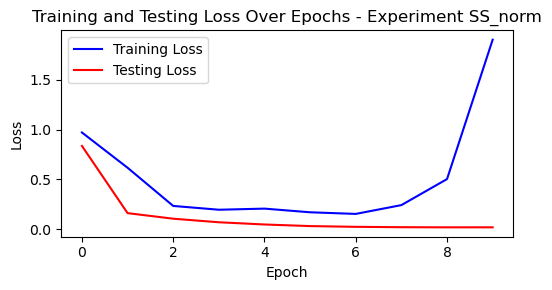

EVALUATION BATCH SIZE 1 START
Scaler data
[9.93836543e-01 9.93047294e-01 7.89248418e-04 7.12070125e-01]
[0.39909261 0.4013012  0.07285045 0.34816378]
1 torch.Size([1, 4]) torch.Size([1, 1])
Evaluation with real labels PID
RMSE: 0.1680394388998626
MAPE: 41.08335077762604%


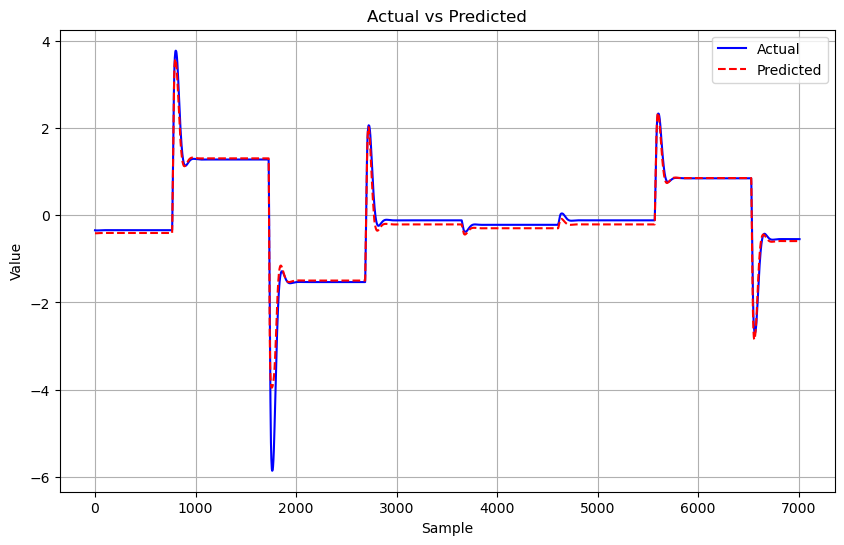

IAE and ISE of model for 1
Integral Absolute Error (IAE): 9.006159321783063
Integral Squared Error (ISE): 2.1866823456103077
Root Mean Squared Error (RMSE): 0.04669224889197906


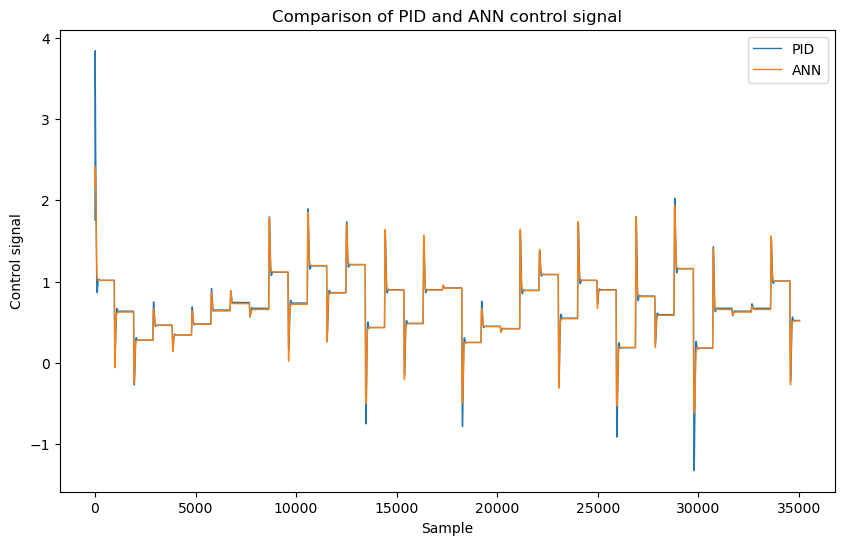

In [63]:
# Load the .mat file
data = scipy.io.loadmat(first_order_processes_mat)

# Extract parameter values
K_values = data['K_values'][0]
T_values = data['T_values'][0]
alpha_values = data['alpha_values'][0]
Kp_values = data['Kp_values'][0]
Ti_values = data['Ti_values'][0]
Td_values = data['Td_values'][0]
beta_values = data['beta_values'][0]
IAE_values = data['IAE_values'][0]
tao_values = data['tao_values'][0]
L_values = data['L_values'][0]


suffix = 'SS_norm'
num_epochs = 100
prev2 = False
coin_false = False
early_stop_thresh = 30
full_val_set = True
stop50 = False
last_epoch_check = False

for i in [0,1,2,3,4,5,6,7,8,9]:
    process = str(i+1)
    print("proces", process)
    pid[process] = [Kp_values[i], Ti_values[i], Td_values[i]/(1+alpha_values[i]*Td_values[i])]
    proces_params[process] = [K_values[i], 0, T_values[i], 1, L_values[i]]
    beta = beta_values[i]
    print("pid['process']", pid[process] )
    print("process_params['process']", proces_params[process] )

    P_folder = pids_mat_dir
    train_and_save_model(process, P_folder, batch_size, test_batch_size, suffix)    


proces 2
pid['process'] [1.8930070211024739, 0.6679342943053866, 0.17383777437419184]
process_params['process'] [1.4, 0, 1.2, 1, 0.38222222222222224]
START of 2
mesura_PID_2
./ETROTLE_Dataset_ETFA24_MAT_files/reference/
Scaler data
[0.99383654 0.99242826 0.00140828 0.71196982]
[0.39909261 0.40780048 0.13133533 0.34026392]
1 torch.Size([1, 4]) torch.Size([1, 1])
LSTM_FF_dropout(
  (lstm1): LSTM(4, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout_dense): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
criterion is ClassicMSELoss()
Reset model parameters no transfer
35041
28032
FULL VAL SET, TRAINING+VAL
new_val_length is  35041


/tmp/ipykernel_34371/2693014458.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss = torch.tensor(inputs[:,0,2]).to(device)


Sched sampl 0 time out of 28032 in the 0 epoch
Epoch(1/100)
Training loss : 0.9651295321347804


/tmp/ipykernel_34371/2693014458.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss2 = torch.tensor(inputs[:,0,2]).to(device)


Validation loss : 0.8407391346569771
Checkpointing new best model in epoch 1
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 272 time out of 28032 in the 1 epoch
Epoch(2/100)
Training loss : 0.44857493589792163
Validation loss : 0.1215723029494711
Checkpointing new best model in epoch 2
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 555 time out of 28032 in the 2 epoch
Epoch(3/100)
Training loss : 0.16110898793438294
Validation loss : 0.08923088874509738
Checkpointing new best model in epoch 3
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 823 time out of 28032 in the 3 epoch
Epoch(4/100)
Training loss : 0.11883857515396169
Validation loss : 0.06296391823486314
Checkpointing new best model in epoch 4
Elapsed Time e: 0 minutes and 52 seconds
Sched sampl 1070 time out of 28032 in the 4 epoch
Epoch(5/100)
Training loss : 0.09650063949112804
Validation loss : 0.04535327401040865
Checkpointing new best model in epoch 5
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 14

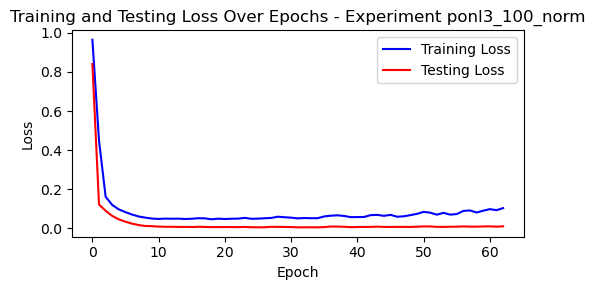

EVALUATION BATCH SIZE 1 START
Scaler data
[0.99383654 0.99242826 0.00140828 0.71196982]
[0.39909261 0.40780048 0.13133533 0.34026392]
1 torch.Size([1, 4]) torch.Size([1, 1])
Evaluation with real labels PID
Counter of batches test is 7009
RMSE: 0.08556845274661068
MAPE: 60.229527950286865%


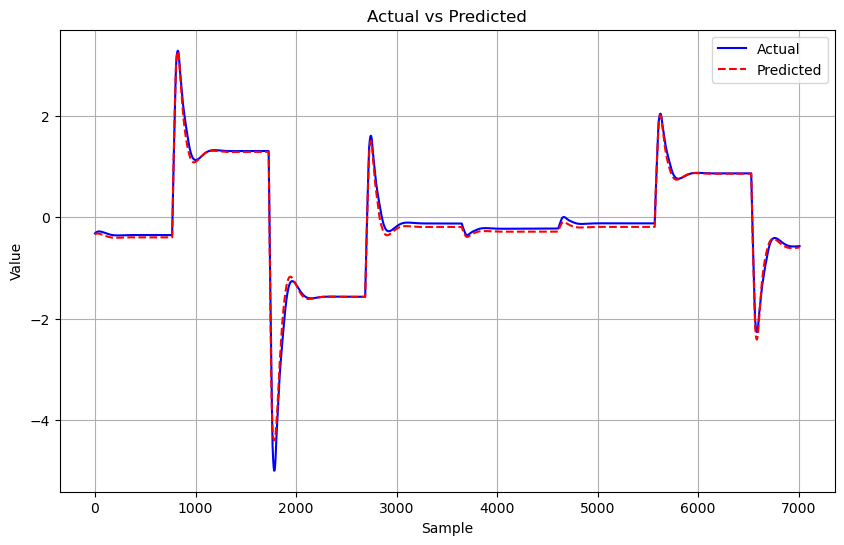

IAE and ISE of model for 2
Integral Absolute Error (IAE): 17.391198340309167
Integral Squared Error (ISE): 6.434038308424371
Root Mean Squared Error (RMSE): 0.04224459263188595


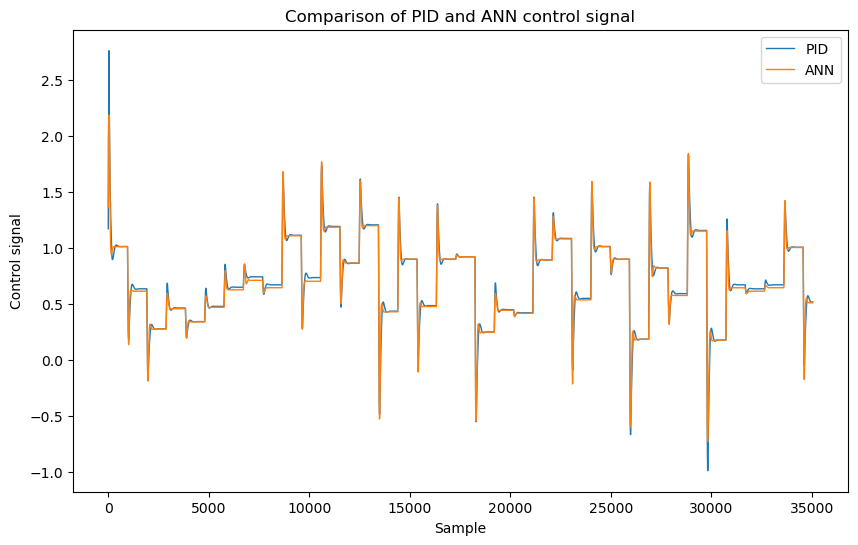

proces 3
pid['process'] [1.2457535117843213, 0.9049680118710275, 0.26586677562922423]
process_params['process'] [1.4, 0, 1.2, 1, 0.6344444444444445]
START of 3
mesura_PID_3
./ETROTLE_Dataset_ETFA24_MAT_files/reference/
Scaler data
[0.99383654 0.99166459 0.00217195 0.71188507]
[0.39909261 0.41138864 0.17525011 0.33057107]
1 torch.Size([1, 4]) torch.Size([1, 1])
LSTM_FF_dropout(
  (lstm1): LSTM(4, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout_dense): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
criterion is ClassicMSELoss()
Reset model parameters no transfer
35041
28032
FULL VAL SET, TRAINING+VAL
new_val_length is  35041


/tmp/ipykernel_34371/2693014458.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss = torch.tensor(inputs[:,0,2]).to(device)


Sched sampl 0 time out of 28032 in the 0 epoch
Epoch(1/100)
Training loss : 0.9409819094009673


/tmp/ipykernel_34371/2693014458.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss2 = torch.tensor(inputs[:,0,2]).to(device)


Validation loss : 0.7379518727232455
Checkpointing new best model in epoch 1
Elapsed Time e: 0 minutes and 52 seconds
Sched sampl 262 time out of 28032 in the 1 epoch
Epoch(2/100)
Training loss : 0.3274963272998637
Validation loss : 0.07017300254192135
Checkpointing new best model in epoch 2
Elapsed Time e: 0 minutes and 53 seconds
Sched sampl 552 time out of 28032 in the 2 epoch
Epoch(3/100)
Training loss : 0.09735025984713977
Validation loss : 0.05157924389121342
Checkpointing new best model in epoch 3
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 866 time out of 28032 in the 3 epoch
Epoch(4/100)
Training loss : 0.08015369841368067
Validation loss : 0.03973943043539922
Checkpointing new best model in epoch 4
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 1136 time out of 28032 in the 4 epoch
Epoch(5/100)
Training loss : 0.06936214680890926
Validation loss : 0.029889797240952597
Checkpointing new best model in epoch 5
Elapsed Time e: 0 minutes and 52 seconds
Sched sampl 1

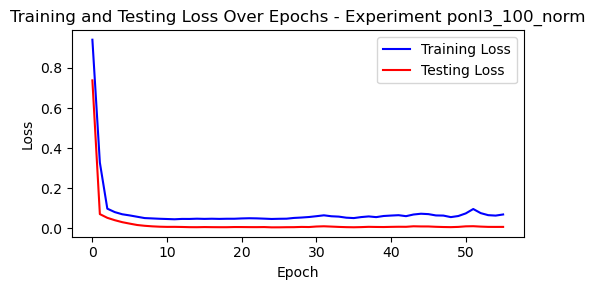

EVALUATION BATCH SIZE 1 START
Scaler data
[0.99383654 0.99166459 0.00217195 0.71188507]
[0.39909261 0.41138864 0.17525011 0.33057107]
1 torch.Size([1, 4]) torch.Size([1, 1])
Evaluation with real labels PID
Counter of batches test is 7009
RMSE: 0.080998875647564
MAPE: 53.13931703567505%


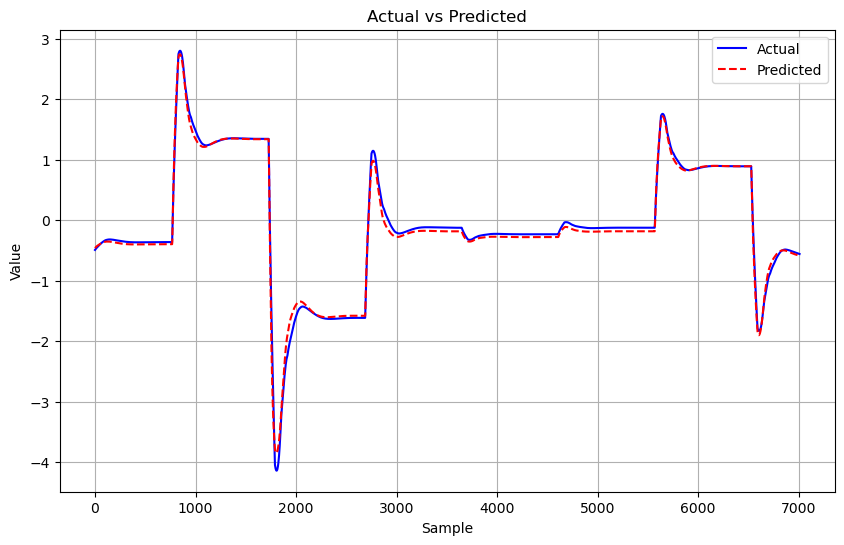

IAE and ISE of model for 3
Integral Absolute Error (IAE): 25.214627581892366
Integral Squared Error (ISE): 11.241211428881456
Root Mean Squared Error (RMSE): 0.04362625305940923


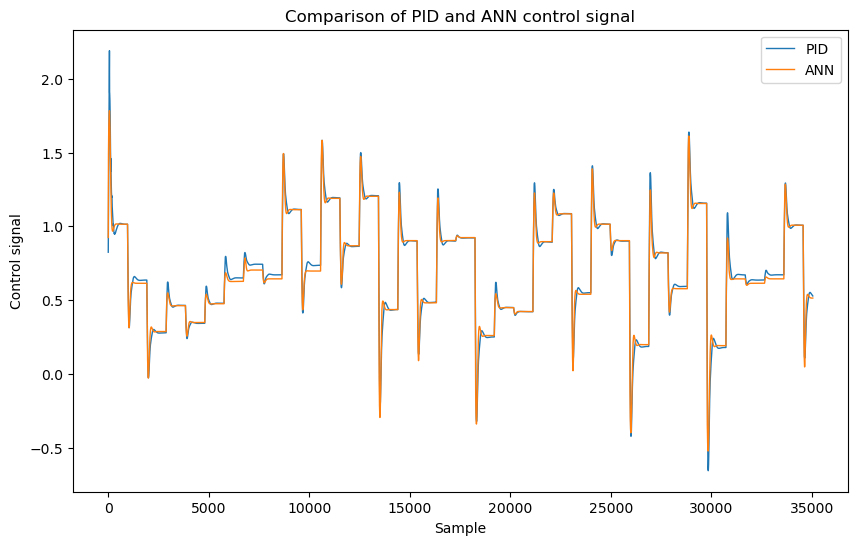

proces 4
pid['process'] [0.9591564864074413, 1.09942662216567, 0.3510946113098164]
process_params['process'] [1.4, 0, 1.2, 1, 0.8866666666666667]
START of 4
mesura_PID_4
./ETROTLE_Dataset_ETFA24_MAT_files/reference/
Scaler data
[0.99383654 0.99074398 0.00309256 0.71182935]
[0.39909261 0.4136841  0.20905688 0.32422644]
1 torch.Size([1, 4]) torch.Size([1, 1])
LSTM_FF_dropout(
  (lstm1): LSTM(4, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout_dense): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
criterion is ClassicMSELoss()
Reset model parameters no transfer
35041
28032
FULL VAL SET, TRAINING+VAL
new_val_length is  35041


/tmp/ipykernel_34371/2693014458.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss = torch.tensor(inputs[:,0,2]).to(device)


Sched sampl 0 time out of 28032 in the 0 epoch
Epoch(1/100)
Training loss : 0.999941731040763


/tmp/ipykernel_34371/2693014458.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss2 = torch.tensor(inputs[:,0,2]).to(device)


Validation loss : 0.8854258039859574
Checkpointing new best model in epoch 1
Elapsed Time e: 0 minutes and 52 seconds
Sched sampl 283 time out of 28032 in the 1 epoch
Epoch(2/100)
Training loss : 0.47270404955254675
Validation loss : 0.07255365810001231
Checkpointing new best model in epoch 2
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 555 time out of 28032 in the 2 epoch
Epoch(3/100)
Training loss : 0.1196879433973809
Validation loss : 0.05697882733080862
Checkpointing new best model in epoch 3
Elapsed Time e: 0 minutes and 49 seconds
Sched sampl 877 time out of 28032 in the 3 epoch
Epoch(4/100)
Training loss : 0.09319009849492353
Validation loss : 0.04311535541474434
Checkpointing new best model in epoch 4
Elapsed Time e: 0 minutes and 54 seconds
Sched sampl 1146 time out of 28032 in the 4 epoch
Epoch(5/100)
Training loss : 0.07938121780755665
Validation loss : 0.03193131816389837
Checkpointing new best model in epoch 5
Elapsed Time e: 0 minutes and 50 seconds
Sched sampl 13

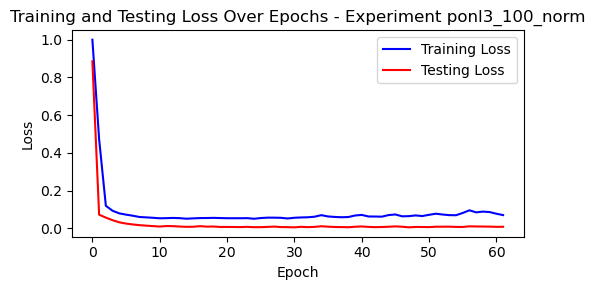

EVALUATION BATCH SIZE 1 START
Scaler data
[0.99383654 0.99074398 0.00309256 0.71182935]
[0.39909261 0.4136841  0.20905688 0.32422644]
1 torch.Size([1, 4]) torch.Size([1, 1])
Evaluation with real labels PID
Counter of batches test is 7009
RMSE: 0.08919276499252998
MAPE: 81.43101930618286%


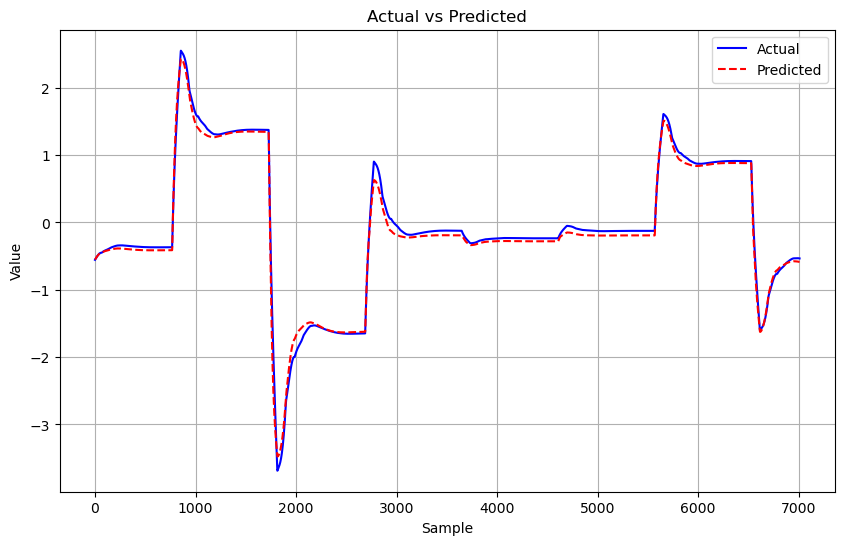

IAE and ISE of model for 4
Integral Absolute Error (IAE): 35.28609975872377
Integral Squared Error (ISE): 16.023553739332527
Root Mean Squared Error (RMSE): 0.048192168231244795


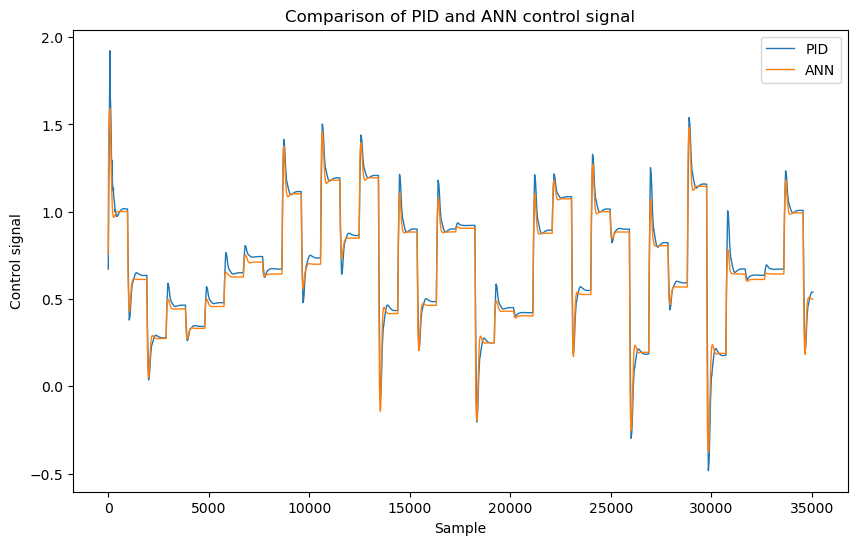

proces 5
pid['process'] [0.7965388336804098, 1.2686150174434931, 0.43148388771821705]
process_params['process'] [1.4, 0, 1.2, 1, 1.1388888888888888]
START of 5
mesura_PID_5
./ETROTLE_Dataset_ETFA24_MAT_files/reference/
Scaler data
[0.99383654 0.98965375 0.00418279 0.71176873]
[0.39909261 0.41522266 0.2365999  0.31950205]
1 torch.Size([1, 4]) torch.Size([1, 1])
LSTM_FF_dropout(
  (lstm1): LSTM(4, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout_dense): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
criterion is ClassicMSELoss()
Reset model parameters no transfer
35041
28032
FULL VAL SET, TRAINING+VAL
new_val_length is  35041


/tmp/ipykernel_34371/2693014458.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss = torch.tensor(inputs[:,0,2]).to(device)


Sched sampl 0 time out of 28032 in the 0 epoch
Epoch(1/100)
Training loss : 0.9740484376975804


/tmp/ipykernel_34371/2693014458.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss2 = torch.tensor(inputs[:,0,2]).to(device)


Validation loss : 0.8251356978294077
Checkpointing new best model in epoch 1
Elapsed Time e: 0 minutes and 53 seconds
Sched sampl 284 time out of 28032 in the 1 epoch
Epoch(2/100)
Training loss : 0.38534169823687076
Validation loss : 0.07282448318498157
Checkpointing new best model in epoch 2
Elapsed Time e: 0 minutes and 54 seconds
Sched sampl 529 time out of 28032 in the 2 epoch
Epoch(3/100)
Training loss : 0.11307090775470004
Validation loss : 0.059700648961779054
Checkpointing new best model in epoch 3
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 774 time out of 28032 in the 3 epoch
Epoch(4/100)
Training loss : 0.09316480950253418
Validation loss : 0.046380394502132764
Checkpointing new best model in epoch 4
Elapsed Time e: 0 minutes and 52 seconds
Sched sampl 1054 time out of 28032 in the 4 epoch
Epoch(5/100)
Training loss : 0.0812516320339711
Validation loss : 0.038297707805155505
Checkpointing new best model in epoch 5
Elapsed Time e: 0 minutes and 52 seconds
Sched sampl

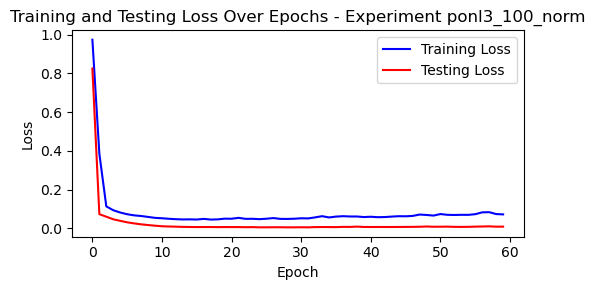

EVALUATION BATCH SIZE 1 START
Scaler data
[0.99383654 0.98965375 0.00418279 0.71176873]
[0.39909261 0.41522266 0.2365999  0.31950205]
1 torch.Size([1, 4]) torch.Size([1, 1])
Evaluation with real labels PID
Counter of batches test is 7009
RMSE: 0.0918290374089552
MAPE: 132.1064829826355%


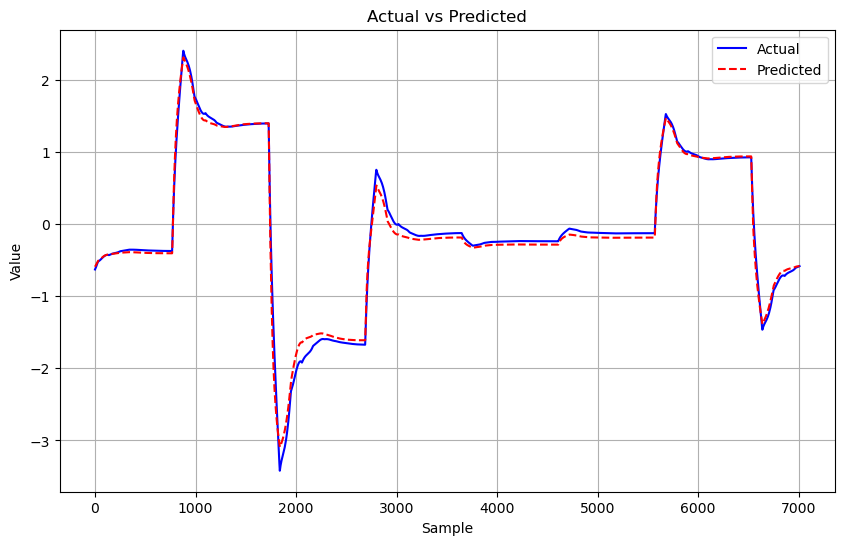

IAE and ISE of model for 5
Integral Absolute Error (IAE): 39.81643189774759
Integral Squared Error (ISE): 20.491433819576592
Root Mean Squared Error (RMSE): 0.048982916806521455


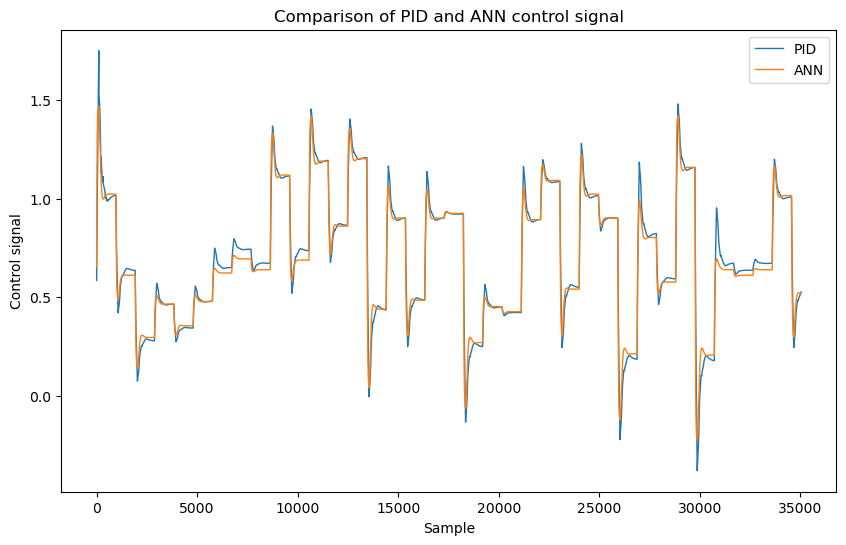

proces 6
pid['process'] [0.6914203558263329, 1.4205394290139153, 0.5080783535451837]
process_params['process'] [1.4, 0, 1.2, 1, 1.391111111111111]
START of 6
mesura_PID_6
./ETROTLE_Dataset_ETFA24_MAT_files/reference/
Scaler data
[0.99383654 0.98847489 0.00536165 0.71170676]
[0.39909261 0.41648785 0.26032551 0.31597014]
1 torch.Size([1, 4]) torch.Size([1, 1])
LSTM_FF_dropout(
  (lstm1): LSTM(4, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout_dense): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
criterion is ClassicMSELoss()
Reset model parameters no transfer
35041
28032
FULL VAL SET, TRAINING+VAL
new_val_length is  35041


/tmp/ipykernel_34371/2693014458.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss = torch.tensor(inputs[:,0,2]).to(device)


Sched sampl 0 time out of 28032 in the 0 epoch
Epoch(1/100)
Training loss : 0.9390384317217709


/tmp/ipykernel_34371/2693014458.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss2 = torch.tensor(inputs[:,0,2]).to(device)


Validation loss : 0.7619629734783506
Checkpointing new best model in epoch 1
Elapsed Time e: 0 minutes and 57 seconds
Sched sampl 259 time out of 28032 in the 1 epoch
Epoch(2/100)
Training loss : 0.3386765942249826
Validation loss : 0.04853278271997636
Checkpointing new best model in epoch 2
Elapsed Time e: 0 minutes and 50 seconds
Sched sampl 590 time out of 28032 in the 2 epoch
Epoch(3/100)
Training loss : 0.0935049189334355
Validation loss : 0.048380390214372154
Checkpointing new best model in epoch 3
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 854 time out of 28032 in the 3 epoch
Epoch(4/100)
Training loss : 0.08371016216440451
Validation loss : 0.04084831755131099
Checkpointing new best model in epoch 4
Elapsed Time e: 0 minutes and 53 seconds
Sched sampl 1153 time out of 28032 in the 4 epoch
Epoch(5/100)
Training loss : 0.07667642226311257
Validation loss : 0.033013636483402255
Checkpointing new best model in epoch 5
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 1

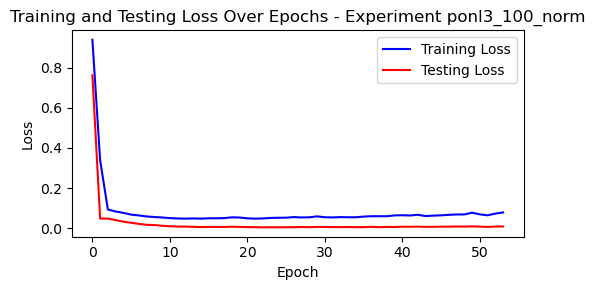

EVALUATION BATCH SIZE 1 START
Scaler data
[0.99383654 0.98847489 0.00536165 0.71170676]
[0.39909261 0.41648785 0.26032551 0.31597014]
1 torch.Size([1, 4]) torch.Size([1, 1])
Evaluation with real labels PID
Counter of batches test is 7009
RMSE: 0.08945245990187856
MAPE: 56.343644857406616%


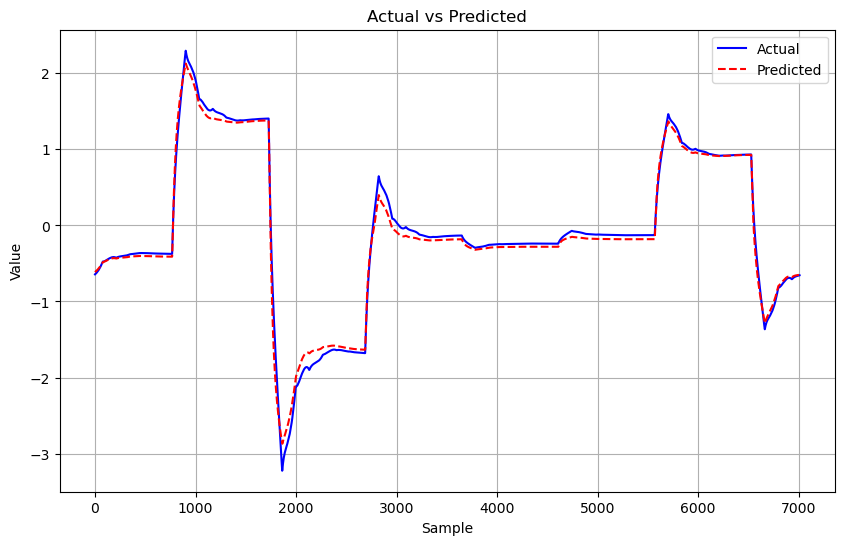

IAE and ISE of model for 6
Integral Absolute Error (IAE): 47.39109134552414
Integral Squared Error (ISE): 24.861345368738984
Root Mean Squared Error (RMSE): 0.05232913691360844


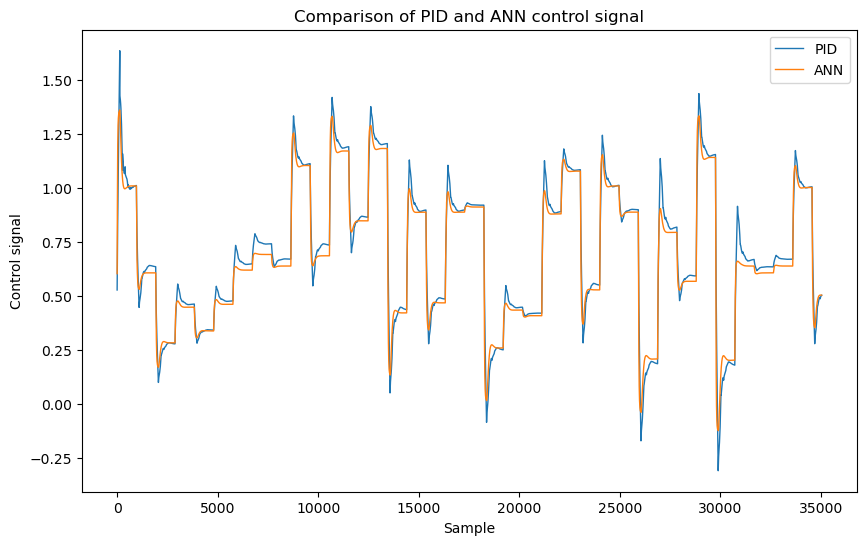

proces 7
pid['process'] [0.6177321556370109, 1.5596920003928807, 0.5815307539504232]
process_params['process'] [1.4, 0, 1.2, 1, 1.6433333333333335]
START of 7
mesura_PID_7
./ETROTLE_Dataset_ETFA24_MAT_files/reference/
Scaler data
[0.99383654 0.98726011 0.00657644 0.71163527]
[0.39909261 0.41764562 0.2820713  0.31334575]
1 torch.Size([1, 4]) torch.Size([1, 1])
LSTM_FF_dropout(
  (lstm1): LSTM(4, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout_dense): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
criterion is ClassicMSELoss()
Reset model parameters no transfer
35041
28032
FULL VAL SET, TRAINING+VAL
new_val_length is  35041


/tmp/ipykernel_34371/2693014458.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss = torch.tensor(inputs[:,0,2]).to(device)


Sched sampl 0 time out of 28032 in the 0 epoch
Epoch(1/100)
Training loss : 0.9523881116003939


/tmp/ipykernel_34371/2693014458.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss2 = torch.tensor(inputs[:,0,2]).to(device)


Validation loss : 0.7930619096955448
Checkpointing new best model in epoch 1
Elapsed Time e: 0 minutes and 48 seconds
Sched sampl 266 time out of 28032 in the 1 epoch
Epoch(2/100)
Training loss : 0.39352291071019707
Validation loss : 0.05449785452888399
Checkpointing new best model in epoch 2
Elapsed Time e: 0 minutes and 49 seconds
Sched sampl 537 time out of 28032 in the 2 epoch
Epoch(3/100)
Training loss : 0.10785948528725521
Validation loss : 0.0553095893985926
Elapsed Time e: 0 minutes and 52 seconds
Sched sampl 875 time out of 28032 in the 3 epoch
Epoch(4/100)
Training loss : 0.08980023781950387
Validation loss : 0.04182408184377647
Checkpointing new best model in epoch 4
Elapsed Time e: 0 minutes and 56 seconds
Sched sampl 1140 time out of 28032 in the 4 epoch
Epoch(5/100)
Training loss : 0.07588112896022993
Validation loss : 0.0314055585083747
Checkpointing new best model in epoch 5
Elapsed Time e: 0 minutes and 53 seconds
Sched sampl 1465 time out of 28032 in the 5 epoch
Epoch

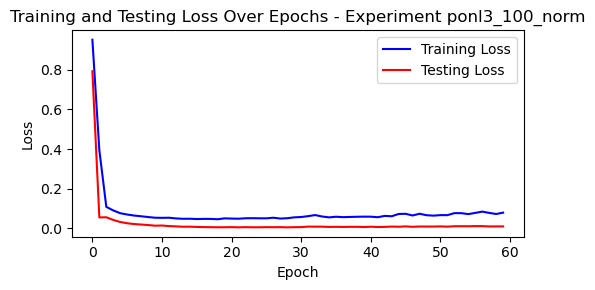

EVALUATION BATCH SIZE 1 START
Scaler data
[0.99383654 0.98726011 0.00657644 0.71163527]
[0.39909261 0.41764562 0.2820713  0.31334575]
1 torch.Size([1, 4]) torch.Size([1, 1])
Evaluation with real labels PID
Counter of batches test is 7009
RMSE: 0.0870335471110521
MAPE: 46.35186493396759%


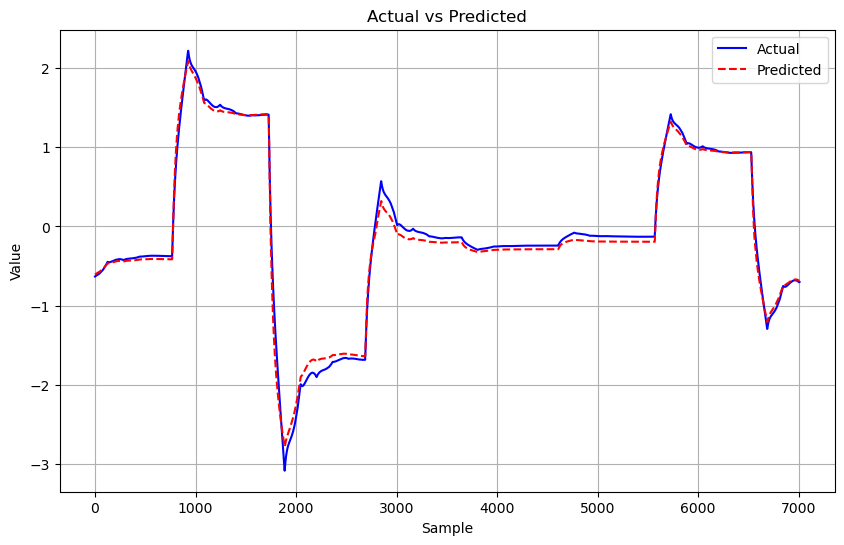

IAE and ISE of model for 7
Integral Absolute Error (IAE): 53.865162859703105
Integral Squared Error (ISE): 29.6049673002778
Root Mean Squared Error (RMSE): 0.05547235871719217


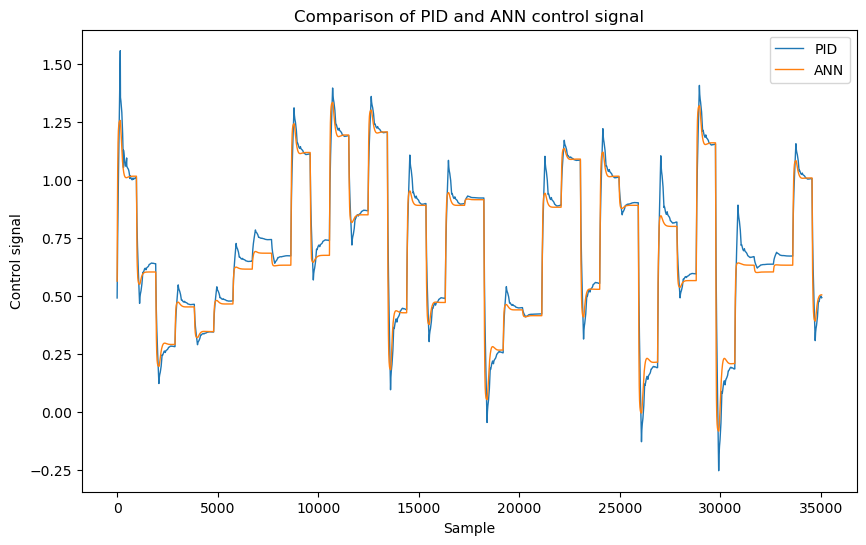

proces 8
pid['process'] [0.5631306156051781, 1.6888947008253725, 0.652290244183168]
process_params['process'] [1.4, 0, 1.2, 1, 1.8955555555555557]
START of 8
mesura_PID_8
./ETROTLE_Dataset_ETFA24_MAT_files/reference/
Scaler data
[0.99383654 0.98602249 0.00781405 0.71156602]
[0.39909261 0.41869169 0.30288651 0.31129626]
1 torch.Size([1, 4]) torch.Size([1, 1])
LSTM_FF_dropout(
  (lstm1): LSTM(4, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout_dense): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
criterion is ClassicMSELoss()
Reset model parameters no transfer
35041
28032
FULL VAL SET, TRAINING+VAL
new_val_length is  35041


/tmp/ipykernel_34371/2693014458.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss = torch.tensor(inputs[:,0,2]).to(device)


Sched sampl 0 time out of 28032 in the 0 epoch
Epoch(1/100)
Training loss : 0.9382993946459084


/tmp/ipykernel_34371/2693014458.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss2 = torch.tensor(inputs[:,0,2]).to(device)


Validation loss : 0.7309215079320437
Checkpointing new best model in epoch 1
Elapsed Time e: 0 minutes and 53 seconds
Sched sampl 292 time out of 28032 in the 1 epoch
Epoch(2/100)
Training loss : 0.3116373957327654
Validation loss : 0.04282988623892848
Checkpointing new best model in epoch 2
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 548 time out of 28032 in the 2 epoch
Epoch(3/100)
Training loss : 0.085154159845359
Validation loss : 0.046147282120714714
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 842 time out of 28032 in the 3 epoch
Epoch(4/100)
Training loss : 0.08028314255557732
Validation loss : 0.03980884537970479
Checkpointing new best model in epoch 4
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 1188 time out of 28032 in the 4 epoch
Epoch(5/100)
Training loss : 0.07459824862000458
Validation loss : 0.03236752032513119
Checkpointing new best model in epoch 5
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 1385 time out of 28032 in the 5 epoch
Epoch

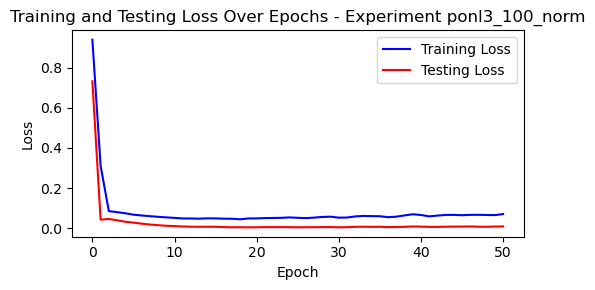

EVALUATION BATCH SIZE 1 START
Scaler data
[0.99383654 0.98602249 0.00781405 0.71156602]
[0.39909261 0.41869169 0.30288651 0.31129626]
1 torch.Size([1, 4]) torch.Size([1, 1])
Evaluation with real labels PID
Counter of batches test is 7009
RMSE: 0.09069317733865835
MAPE: 360.2640628814697%


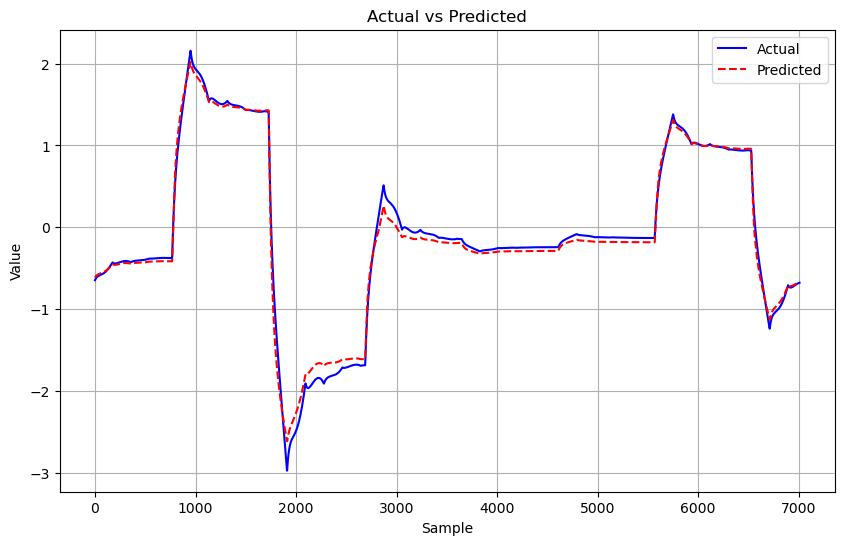

IAE and ISE of model for 8
Integral Absolute Error (IAE): 60.901981902446735
Integral Squared Error (ISE): 34.424280760443466
Root Mean Squared Error (RMSE): 0.05969908288131239


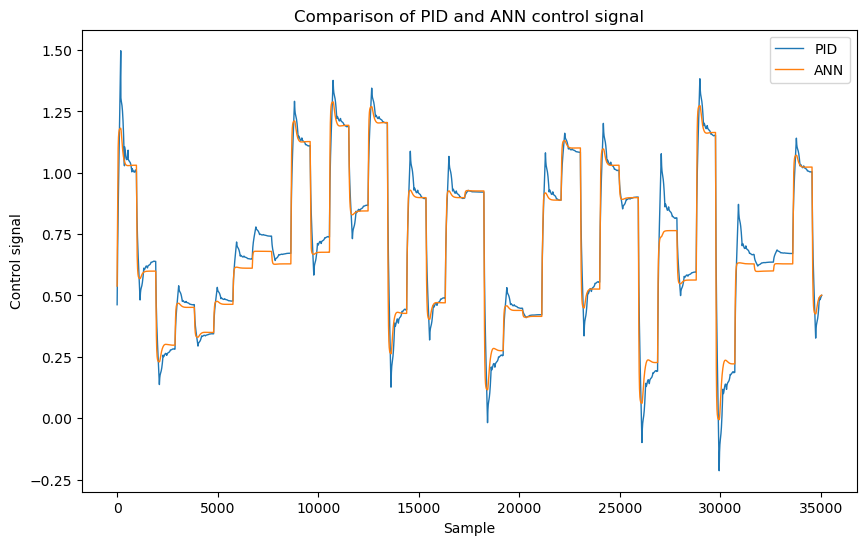

proces 9
pid['process'] [0.5210040767955192, 1.8100586384471267, 0.7206861882376678]
process_params['process'] [1.4, 0, 1.2, 1, 2.147777777777778]
START of 9
mesura_PID_9
./ETROTLE_Dataset_ETFA24_MAT_files/reference/
Scaler data
[0.99383654 0.98476675 0.00906979 0.71150718]
[0.39909261 0.41962938 0.32321588 0.3096711 ]
1 torch.Size([1, 4]) torch.Size([1, 1])
LSTM_FF_dropout(
  (lstm1): LSTM(4, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout_dense): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
criterion is ClassicMSELoss()
Reset model parameters no transfer
35041
28032
FULL VAL SET, TRAINING+VAL
new_val_length is  35041


/tmp/ipykernel_34371/2693014458.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss = torch.tensor(inputs[:,0,2]).to(device)


Sched sampl 0 time out of 28032 in the 0 epoch
Epoch(1/100)
Training loss : 0.9305019261536046


/tmp/ipykernel_34371/2693014458.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss2 = torch.tensor(inputs[:,0,2]).to(device)


Validation loss : 0.6862325969787789
Checkpointing new best model in epoch 1
Elapsed Time e: 0 minutes and 53 seconds
Sched sampl 278 time out of 28032 in the 1 epoch
Epoch(2/100)
Training loss : 0.4005483255432559
Validation loss : 0.22360434312262262
Checkpointing new best model in epoch 2
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 578 time out of 28032 in the 2 epoch
Epoch(3/100)
Training loss : 0.12818937988399406
Validation loss : 0.06401614599654425
Checkpointing new best model in epoch 3
Elapsed Time e: 0 minutes and 52 seconds
Sched sampl 823 time out of 28032 in the 3 epoch
Epoch(4/100)
Training loss : 0.09131062584256791
Validation loss : 0.04328568053760231
Checkpointing new best model in epoch 4
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 1122 time out of 28032 in the 4 epoch
Epoch(5/100)
Training loss : 0.07852456559094896
Validation loss : 0.03290142929393966
Checkpointing new best model in epoch 5
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 14

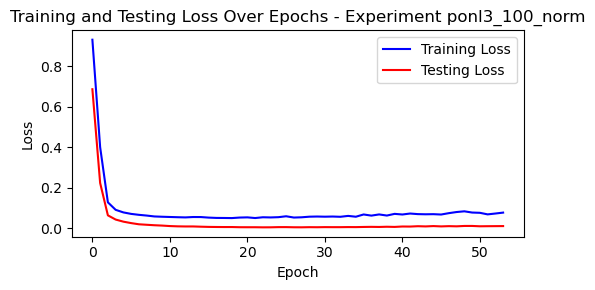

EVALUATION BATCH SIZE 1 START
Scaler data
[0.99383654 0.98476675 0.00906979 0.71150718]
[0.39909261 0.41962938 0.32321588 0.3096711 ]
1 torch.Size([1, 4]) torch.Size([1, 1])
Evaluation with real labels PID
Counter of batches test is 7009
RMSE: 0.09380947984329721
MAPE: 47.3859429359436%


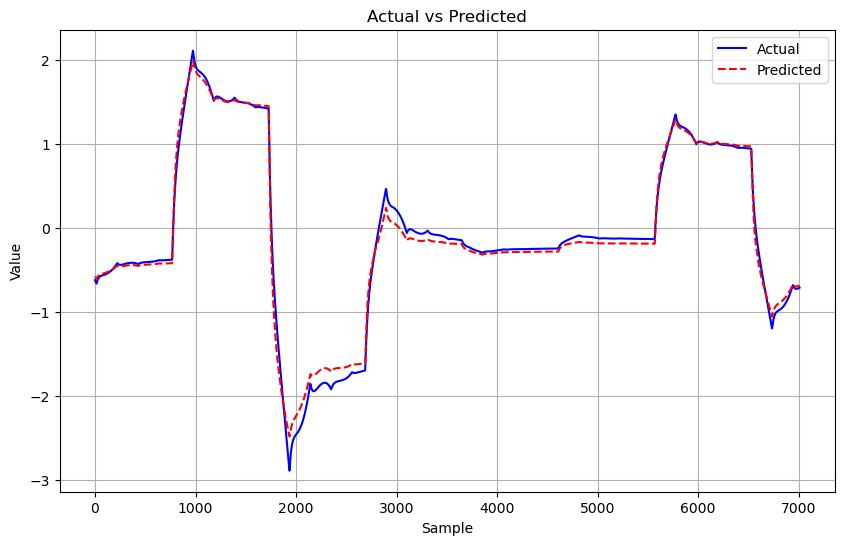

IAE and ISE of model for 9
Integral Absolute Error (IAE): 66.28575569781958
Integral Squared Error (ISE): 38.50345638863343
Root Mean Squared Error (RMSE): 0.06108486984846259


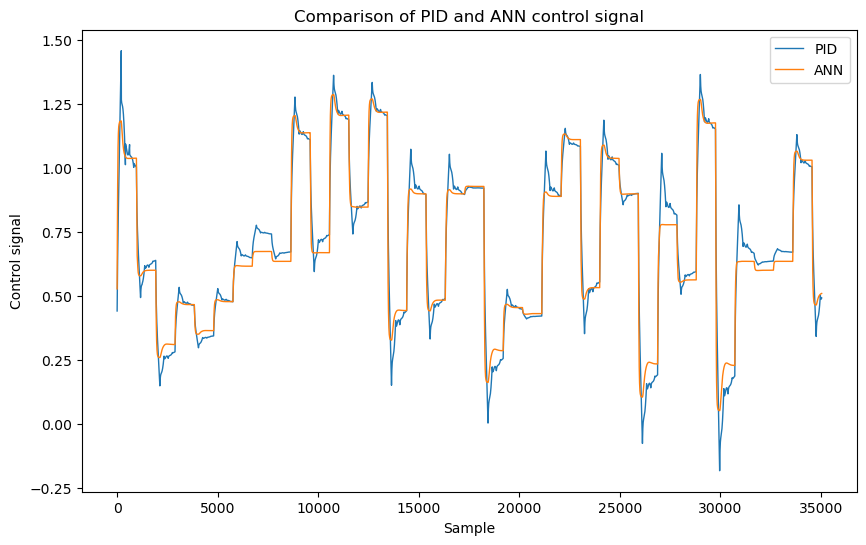

proces 10
pid['process'] [0.4874870959137099, 1.924549682752339, 0.7869713540446732]
process_params['process'] [1.4, 0, 1.2, 1, 2.4]
START of 10
mesura_PID_10
./ETROTLE_Dataset_ETFA24_MAT_files/reference/
Scaler data
[0.99383654 0.98348482 0.01035172 0.71144174]
[0.39909261 0.42044047 0.34263072 0.30833738]
1 torch.Size([1, 4]) torch.Size([1, 1])
LSTM_FF_dropout(
  (lstm1): LSTM(4, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout_dense): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
criterion is ClassicMSELoss()
Reset model parameters no transfer
35041
28032
FULL VAL SET, TRAINING+VAL
new_val_length is  35041


/tmp/ipykernel_34371/2693014458.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss = torch.tensor(inputs[:,0,2]).to(device)


Sched sampl 0 time out of 28032 in the 0 epoch
Epoch(1/100)
Training loss : 0.9509199767093272


/tmp/ipykernel_34371/2693014458.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error_loss2 = torch.tensor(inputs[:,0,2]).to(device)


Validation loss : 0.7879126462808325
Checkpointing new best model in epoch 1
Elapsed Time e: 0 minutes and 51 seconds
Sched sampl 296 time out of 28032 in the 1 epoch
Epoch(2/100)
Training loss : 0.38680149341163483
Validation loss : 0.047759051489534965
Checkpointing new best model in epoch 2
Elapsed Time e: 0 minutes and 50 seconds
Sched sampl 614 time out of 28032 in the 2 epoch
Epoch(3/100)
Training loss : 0.10572844815209555
Validation loss : 0.04675641834513516
Checkpointing new best model in epoch 3
Elapsed Time e: 0 minutes and 52 seconds
Sched sampl 874 time out of 28032 in the 3 epoch
Epoch(4/100)
Training loss : 0.09126951603356213
Validation loss : 0.03713463439257654
Checkpointing new best model in epoch 4
Elapsed Time e: 0 minutes and 54 seconds
Sched sampl 1110 time out of 28032 in the 4 epoch
Epoch(5/100)
Training loss : 0.07955253695282932
Validation loss : 0.029888621730759693
Checkpointing new best model in epoch 5
Elapsed Time e: 0 minutes and 52 seconds
Sched sampl

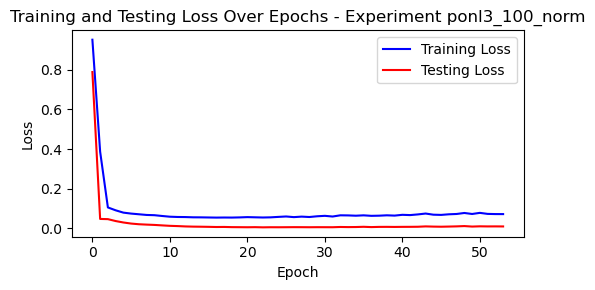

EVALUATION BATCH SIZE 1 START
Scaler data
[0.99383654 0.98348482 0.01035172 0.71144174]
[0.39909261 0.42044047 0.34263072 0.30833738]
1 torch.Size([1, 4]) torch.Size([1, 1])
Evaluation with real labels PID
Counter of batches test is 7009
RMSE: 0.09900108387231839
MAPE: 37.40690350532532%


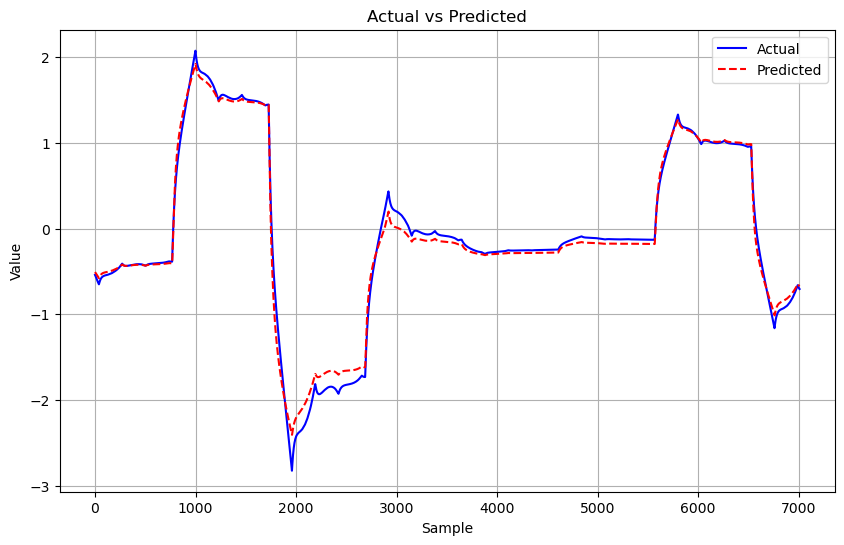

IAE and ISE of model for 10
Integral Absolute Error (IAE): 71.30184082794136
Integral Squared Error (ISE): 41.993903395746116
Root Mean Squared Error (RMSE): 0.06526905518151956


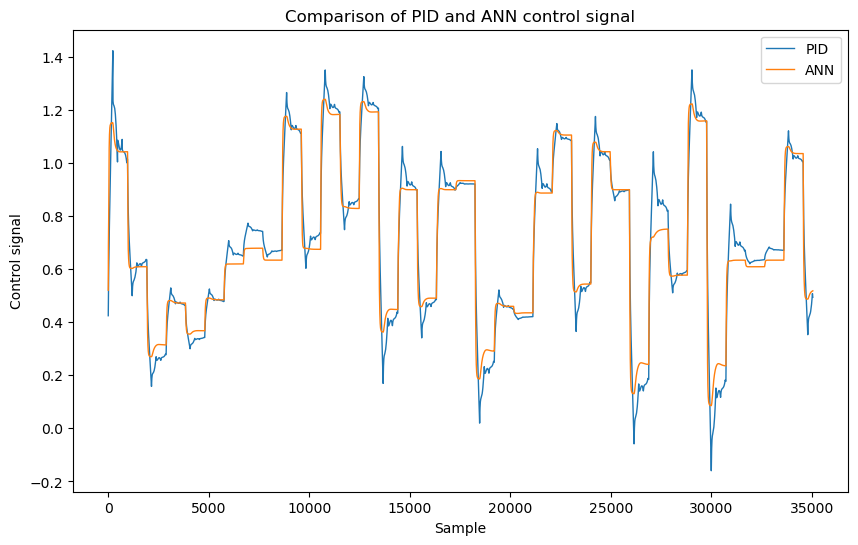